In [1]:
#!pip install -q rioxarray
#!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q monai


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [1]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '3' #cannot work

In [2]:
import numpy as np
from scipy.ndimage import label
from PIL import Image
import rioxarray
import xarray as xr
import matplotlib.pyplot as plt
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np 
import rasterio
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pathlib
import torch.nn.functional as F

In [3]:
import torch

In [4]:
from tqdm import tqdm

In [5]:
# from https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/SAM/Fine_tune_SAM_(segment_anything)_on_a_custom_dataset.ipynb
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [6]:
imagedir = Path('/home/data/kenya/images/')
maskdir = Path('/home/data/kenya/labels/')

In [7]:
buildingdir = Path('/home/data/kenya-binary-masks/buildings/')
cropsdir = Path('/home/data/kenya-binary-masks/crop_fields/')

In [8]:
image_files = os.listdir('/home/data/kenya/images/')
mask_files = os.listdir('/home/data/kenya/labels/')

In [9]:
max_pool = torch.nn.MaxPool2d(2, stride=2)

In [10]:
class SAMDataset(Dataset):
    
    def __init__(self, 
                 maskdir, imagedir, processor):
        self.processor = processor
        self.mask_dir = pathlib.Path(maskdir)
        self.image_dir = pathlib.Path(imagedir)
        self.mask_paths = self._get_mask_paths()
        self.image_paths = self._get_image_paths()
        assert len(self.mask_paths) == len(self.image_paths)


    def _get_mask_paths(self):
        mask_paths = [
            self.mask_dir.joinpath(i) for i in os.listdir(self.mask_dir) if i.split('_')[0]+'_'+i.split('_')[1]+'.tif']
        mask_paths.sort()
        return mask_paths

    def _get_image_paths(self):
        image_paths = [self.image_dir.joinpath(i.split('_')[0]+'_'+i.split('_')[1]+'.tif') for i in os.listdir(self.mask_dir)]
        image_paths.sort()
        return image_paths
        
    def __len__(self):
        return len(self.mask_paths)

    def __getitem__(self, index):
        def read_tif_as_np_array(path):
            with rasterio.open(path) as src:
                    return src.read()

        image = read_tif_as_np_array(self.image_paths[index])[:3, :, :]
        image = torch.tensor(image, dtype=torch.float32).permute(1,2,0)
        
        
        mask = read_tif_as_np_array(self.mask_paths[index])[0, :, :]
        mask = torch.tensor(mask, dtype=torch.uint8)
        
        prompt = get_bounding_box(mask)
        
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

        inputs = {k:v.squeeze(0) for k,v in inputs.items()}

        inputs["ground_truth_mask"] = mask

        return inputs

In [77]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
untrained_processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [78]:
train_dataset = SAMDataset(maskdir=buildingdir, imagedir=imagedir, processor=processor)
untrained_dataset = SAMDataset(maskdir=buildingdir, imagedir=imagedir, processor=untrained_processor)

In [90]:
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
untrained_dataloader = DataLoader(untrained_dataset, batch_size=1, shuffle=False)

In [169]:
batch_iterator = iter(train_dataloader)
untrained_iterator = iter(untrained_dataloader)
for i in range (10):
    batch = next(batch_iterator)
    untrained_batch = next(untrained_iterator)

In [170]:
untrained_model.to(device)
outputs = untrained_model(pixel_values=untrained_batch["pixel_values"].to(device),
                      input_boxes=untrained_batch["input_boxes"].to(device),
                      multimask_output=False)
untrained_predicted_mask = untrained_processor.image_processor.post_process_masks(
    outputs.pred_masks, 
    untrained_batch["original_sizes"], 
    untrained_batch["reshaped_input_sizes"])[0].float()
untrained_ground_truth_mask = untrained_batch["ground_truth_mask"].float().to(device)

In [171]:
model.to(device)
outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)
predicted_mask = processor.image_processor.post_process_masks(
    outputs.pred_masks, 
    batch["original_sizes"], 
    batch["reshaped_input_sizes"])[0].float()
ground_truth_masks = batch["ground_truth_mask"].float().to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


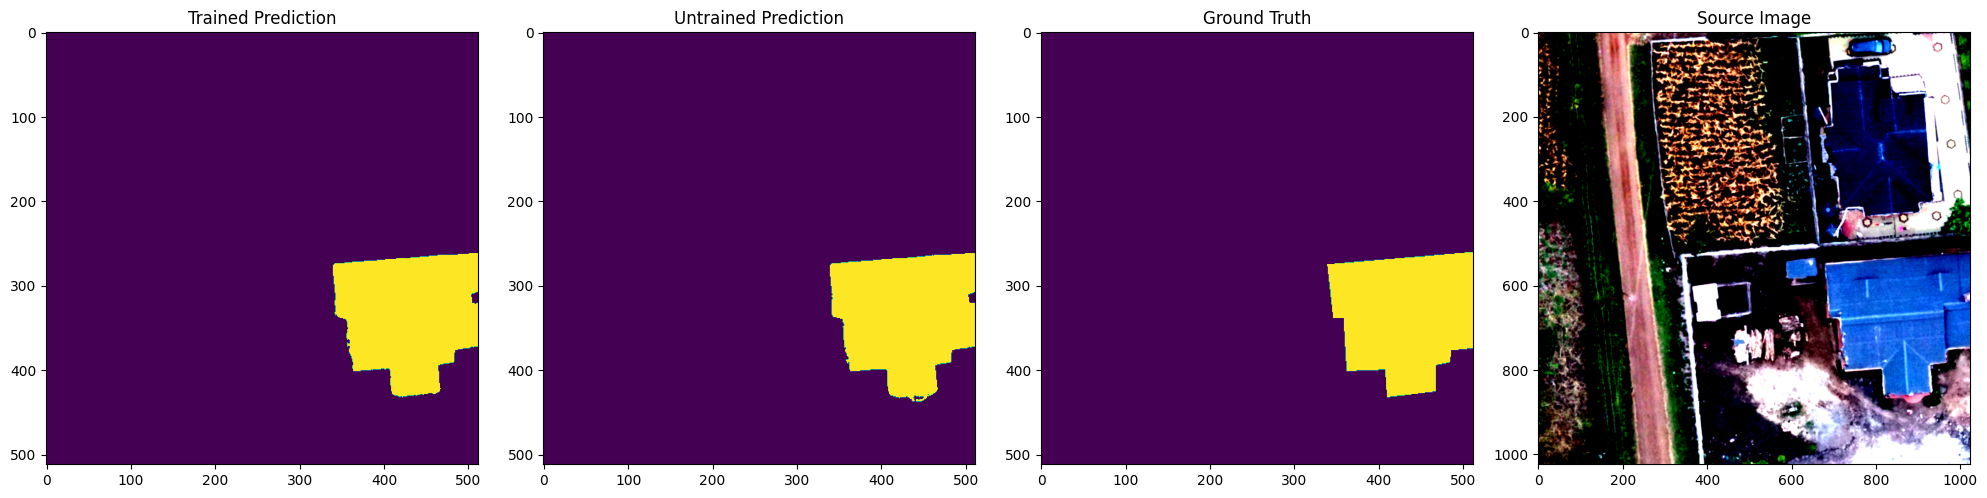

In [173]:
pred = predicted_mask.squeeze(0,1).detach().cpu().numpy()
truth = ground_truth_masks.squeeze(0,1).cpu().numpy()
untrained_pred = untrained_predicted_mask.squeeze(0,1).detach().cpu().numpy()
image = batch["pixel_values"].permute(0,2,3,1).cpu().squeeze(0).numpy()
# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # Adjust figsize for better visualization

# Plot each image on a separate subplot
axes[0].imshow(pred)
axes[1].imshow(untrained_pred)
axes[2].imshow(truth)
axes[3].imshow(image)

# Add titles and adjust layout
axes[0].set_title('Trained Prediction')
axes[1].set_title('Untrained Prediction')
axes[2].set_title('Ground Truth')
axes[3].set_title('Source Image')

# Adjust spacing between plots (optional)
plt.tight_layout()

# Display the plot
plt.show()

In [21]:
from transformers import SamModel 

model = SamModel.from_pretrained("facebook/sam-vit-base")

for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [50]:
untrained_model = SamModel.from_pretrained("facebook/sam-vit-base")

In [18]:
from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

num_epochs = 2

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)
      #print(batch['original_sizes'][0])
      #print(batch['reshaped_input_sizes'][0])
      #for k,v in batch.items():
      #  print(k,v.requires_grad)
      #for k,v in outputs.items():
      #  print(k,v.requires_grad)    
      # compute loss
      predicted_mask = processor.image_processor.post_process_masks(outputs.pred_masks, batch["original_sizes"], batch["reshaped_input_sizes"])[0].float()
      predicted_mask.requires_grad_(True)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_mask, ground_truth_masks.unsqueeze(1))
      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')


In [73]:
pred = predicted_mask.squeeze(0,1).detach().cpu().numpy()

In [74]:
truth = ground_truth_masks.squeeze(0,1).cpu().numpy()

In [67]:
untrained_pred = untrained_predicted_mask.squeeze(0,1).detach().cpu().numpy()

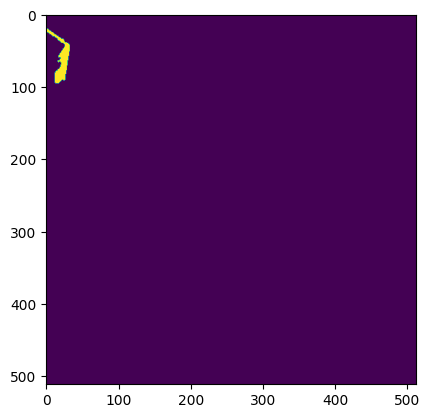

In [68]:
plt.imshow(untrained_pred)

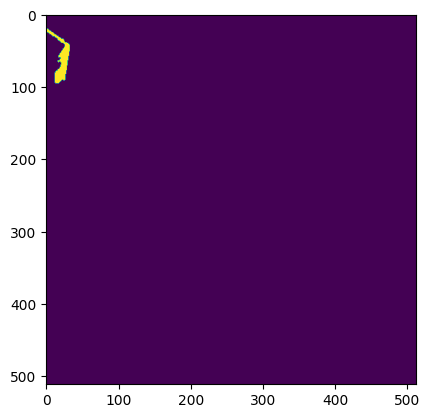

In [75]:
plt.imshow(pred)

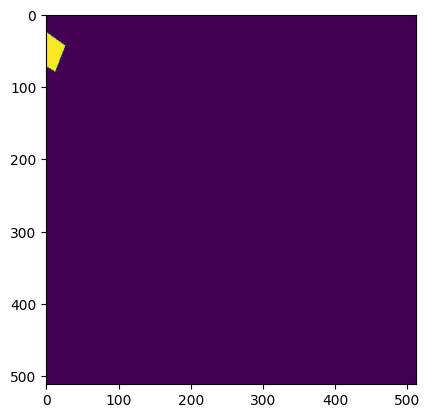

In [76]:
plt.imshow(truth)